In [1]:
import scipy.stats
import numpy as np
import pandas as pd  
import seaborn as sns
from scipy.stats import kstest, kurtosis
import matplotlib.pyplot as plt    

In [2]:
df = pd.read_excel('./data/IPC.xlsx')
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             0 non-null      float64       
 1   Unnamed: 1             0 non-null      float64       
 2   Date                   1162 non-null   datetime64[ns]
 3   IPC                    1162 non-null   float64       
 4   Rendimientos IPC       1161 non-null   float64       
 5   Unnamed: 5             0 non-null      float64       
 6   Oil                    1162 non-null   float64       
 7   Rendimientos Petróleo  1161 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 72.8 KB
None
       Unnamed: 0  Unnamed: 1                           Date           IPC  \
count         0.0         0.0                           1162   1162.000000   
mean          NaN         NaN  2017-07-01 04:17:45.748709120  45765.966821   
min  

In [3]:
# Formatear el DataFrame
df = df[['Date', 'Rendimientos IPC']]
df.set_index('Date', inplace=True)
df = df.drop(df.index[0])
print(df.head())

            Rendimientos IPC
Date                        
2015-01-05         -0.010606
2015-01-06          0.002424
2015-01-07          0.005062
2015-01-08          0.006069
2015-01-09         -0.000204


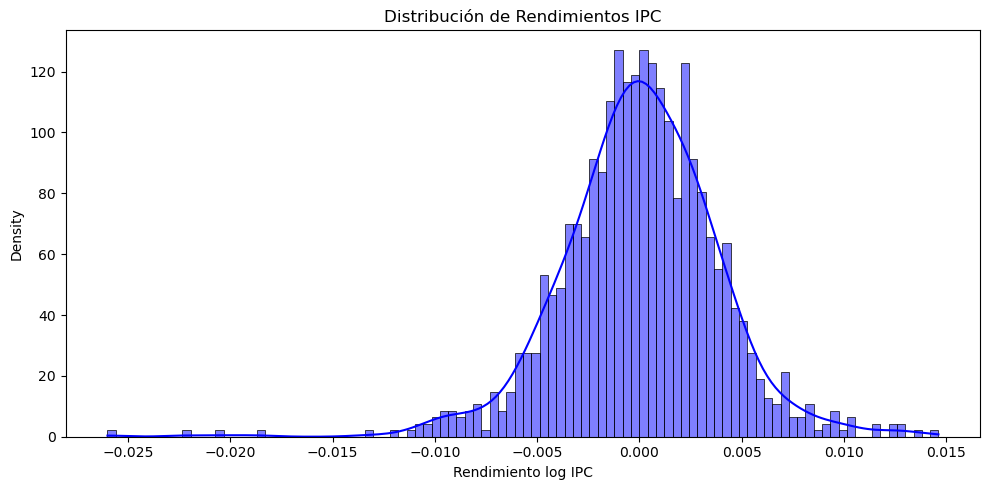

In [4]:
# --- Histograma ---
plt.figure(figsize=(10, 5))
sns.histplot(df["Rendimientos IPC"], bins=100, kde=True, stat="density", color="blue")
plt.title("Distribución de Rendimientos IPC")
plt.xlabel("Rendimiento log IPC")
plt.tight_layout()
plt.show()

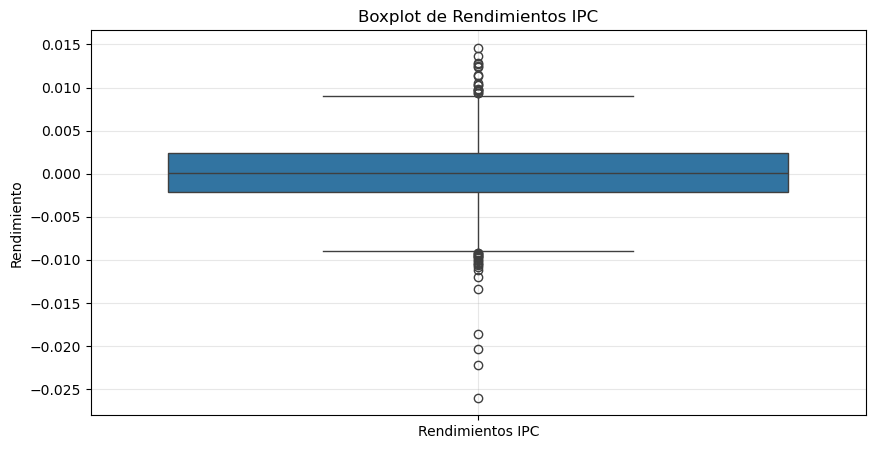

In [5]:
# --- Boxplot ---
plt.figure(figsize=(10, 5))
sns.boxplot(df, vert=True, patch_artist=True)
plt.title("Boxplot de Rendimientos IPC")
plt.ylabel("Rendimiento")
plt.grid(alpha=0.3)
plt.show()

In [6]:
# Curtosis
kurtosis = df.kurtosis()
print("Curtosis:", kurtosis)


Curtosis: Rendimientos IPC    3.963898
dtype: float64


In [7]:
# --- Ajuste por MLE ---
datos = df.values.flatten()  # convertir a array
mu_mle = np.mean(datos)               # media MLE
sigma_mle = np.std(datos, ddof=0)     # desviación estándar MLE (ddof=0)

print(f"Media MLE: {mu_mle:.6f}")
print(f"Desviación estándar MLE: {sigma_mle:.6f}")

Media MLE: 0.000012
Desviación estándar MLE: 0.003893


In [8]:
# KS test para IPC
ks_ipc = kstest(df["Rendimientos IPC"], "laplace", args=(mu_mle, sigma_mle))
print("KS Test IPC -> estadístico:", ks_ipc.statistic, "  p-value:", ks_ipc.pvalue)

KS Test IPC -> estadístico: 0.06952138302224709   p-value: 2.526877209860514e-05


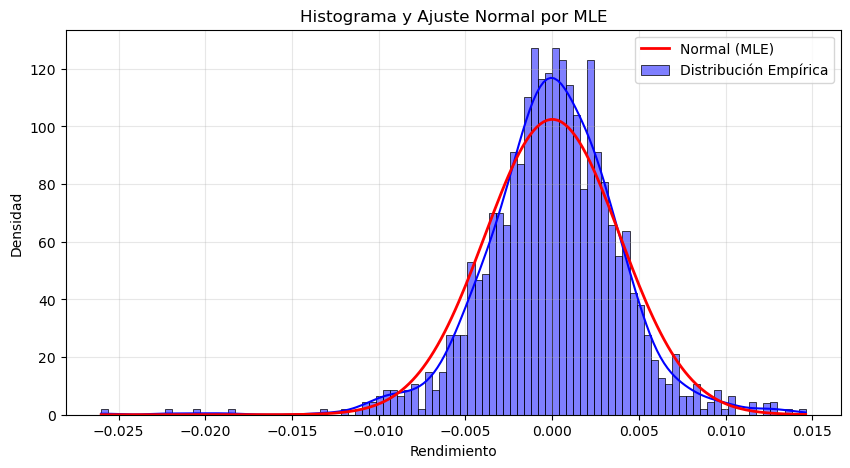

In [9]:
# --- Graficar histograma con densidad normal ---
plt.figure(figsize=(10, 5))
sns.histplot(df["Rendimientos IPC"], bins=100, kde=True, stat="density", color="blue", label='Distribución Empírica')
plt.title("Distribución de Rendimientos IPC")
plt.xlabel("Rendimiento log IPC")

# Curva de la normal ajustada
x = np.linspace(min(datos), max(datos), 200)
pdf = scipy.stats.norm.pdf(x, loc=mu_mle, scale=sigma_mle)
plt.plot(x, pdf, 'r-', lw=2, label='Normal (MLE)')

plt.title("Histograma y Ajuste Normal por MLE")
plt.xlabel("Rendimiento")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [10]:
def pp_plot(data, mu, b, title="PP-Plot"):
    # Probabilidades empíricas
    data_sorted = np.sort(data)
    n = len(data_sorted)
    probs_emp = np.arange(1, n+1) / (n+1)

    # Probabilidades teóricas bajo Laplace
    probs_theo = laplace.cdf(data_sorted, loc=mu, scale=b)

    # Gráfico
    plt.figure(figsize=(6,6))
    plt.plot(probs_emp, probs_theo, "o", alpha=0.6)
    plt.plot([0,1], [0,1], "r--")  # línea ideal
    plt.xlabel("Empírico")
    plt.ylabel("Teórico (Laplace)")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Ejemplo IPC
pp_plot(df["Rendimientos IPC"], mu_mle, sigma_mle, "PP-Plot IPC")

def qq_plot(data, mu, b, title="QQ-Plot"):
    # Ordenamos datos
    data_sorted = np.sort(data)
    n = len(data_sorted)
    
    # Cuantiles teóricos bajo Laplace
    probs = np.arange(1, n+1) / (n+1)
    theo_quants = laplace.ppf(probs, loc=mu, scale=b)
    
    # Gráfico
    plt.figure(figsize=(6,6))
    plt.plot(theo_quants, data_sorted, "o", alpha=0.6)
    min_val = min(data_sorted.min(), theo_quants.min())
    max_val = max(data_sorted.max(), theo_quants.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")  # línea ideal
    plt.xlabel("Cuantiles teóricos (Laplace)")
    plt.ylabel("Cuantiles empíricos")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Ejemplo IPC
qq_plot(df["Rendimientos IPC"], mu_mle, sigma_mle, "QQ-Plot IPC")

NameError: name 'laplace' is not defined

In [ ]:
# Curtosis teórica de una normal ajustada
kurt_fisher = scipy.stats.norm.stats(loc=mu_mle, scale=sigma_mle, moments='k')  # 'k' = kurtosis de Fisher (exceso)
print("Curtosis teórica (exceso de Fisher):", kurt_fisher)
print("Curtosis teórica (Pearson):", float(kurt_fisher) + 3)

Curtosis teórica (exceso de Fisher): 0.0
Curtosis teórica (Pearson): 3.0


In [ ]:
def gmm_em_1d(x, n_comp=2, max_iter=500, tol=1e-6, seed=42):
    """
    EM para una mezcla de n_comp Normales en 1D.
    Retorna: pis (pesos), mus (medias), sigmas (desvios), loglikes (trayectoria).
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x).ravel()
    n = x.size

    # --- Inicialización sencilla: mu por cuantiles, sigma global, pesos uniformes ---
    qs = np.linspace(0.2, 0.8, n_comp)
    mus = np.quantile(x, qs)
    sigmas = np.full(n_comp, x.std(ddof=0) + 1e-8)
    pis = np.full(n_comp, 1.0 / n_comp)

    def loglike(x, pis, mus, sigmas):
        comp = np.array([pis[k] * scipy.stats.norm.pdf(x, mus[k], sigmas[k]) for k in range(n_comp)])  # k x n
        return np.sum(np.log(np.maximum(comp.sum(axis=0), 1e-300)))

    prev_ll = -np.inf
    loglikes = []

    for _ in range(max_iter):
        # --- E-step: responsabilidades r_{ik} ---
        numer = np.array([pis[k] * scipy.stats.norm.pdf(x, mus[k], sigmas[k]) for k in range(n_comp)])  # k x n
        denom = np.maximum(numer.sum(axis=0), 1e-300)                                       # n
        r = (numer / denom).T                                                               # n x k

        # --- M-step: actualizar parámetros ---
        Nk = r.sum(axis=0)                          # tamaño efectivo de cada componente
        pis = Nk / n
        mus = (r * x[:, None]).sum(axis=0) / Nk
        # varianza con responsabilidades
        var = (r * (x[:, None] - mus)**2).sum(axis=0) / Nk
        # regularización mínima por estabilidad numérica
        var = np.maximum(var, 1e-12)
        sigmas = np.sqrt(var)

        # --- Criterio de convergencia ---
        ll = loglike(x, pis, mus, sigmas)
        loglikes.append(ll)
        if abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    return pis, mus, sigmas, loglikes

# Uso:
x = df.values  # 1D
pis, mus, sigmas, lls = gmm_em_1d(x, n_comp=2, max_iter=1000, tol=1e-7, seed=42)
print("Pesos:", pis)
print("Medias:", mus)
print("Sigmas:", sigmas)
print("Log-like final:", lls[-1])


Pesos: [0.13290033 0.86709967]
Medias: [-0.00077737  0.00013351]
Sigmas: [0.00723311 0.0030576 ]
Log-like final: 4847.454255656598


In [ ]:
def gmm_kurtosis_1d(pis, mus, sigmas, return_fisher=True, eps=1e-18):
    pis = np.asarray(pis, dtype=float)
    mus = np.asarray(mus, dtype=float)
    sigmas = np.asarray(sigmas, dtype=float)

    # media total
    mu = np.sum(pis * mus)

    # deltas a la media global
    deltas = mus - mu
    vars_k = sigmas**2

    # varianza total
    V = np.sum(pis * (vars_k + deltas**2))

    # cuarto momento central
    m4 = np.sum(pis * (3*vars_k**2 + 6*vars_k*(deltas**2) + deltas**4))

    # curtosis de Pearson y exceso (Fisher)
    pearson = m4 / max(V**2, eps)
    if return_fisher:
        return pearson - 3.0  # exceso
    else:
        return pearson

# Ejemplo con tus resultados EM:
# pis, mus, sigmas vienen de tu gmm_em_1d(...)
exceso = gmm_kurtosis_1d(pis, mus, sigmas, return_fisher=True)
pearson = exceso + 3
print("Curtosis (exceso de Fisher):", exceso)
print("Curtosis (Pearson):", pearson)


Curtosis (exceso de Fisher): 2.858016828691686
Curtosis (Pearson): 5.858016828691686


In [ ]:
def sample_gmm_1d(n, pis, mus, sigmas, seed=0):
    rng = np.random.default_rng(seed)
    ks = rng.choice(len(pis), size=n, p=pis)
    return rng.normal(mus[ks], sigmas[ks])

x_sim = sample_gmm_1d(1_000_000, pis, mus, sigmas, seed=42)
print("Empírica (Fisher):", scipy.stats.kurtosis(x_sim, fisher=True))
print("Empírica (Pearson):", scipy.stats.kurtosis(x_sim, fisher=False))


Empírica (Fisher): 2.8439004939980714
Empírica (Pearson): 5.843900493998071


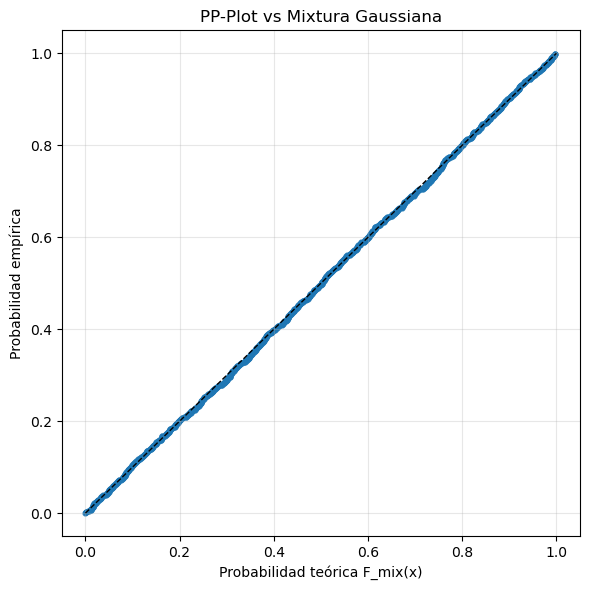

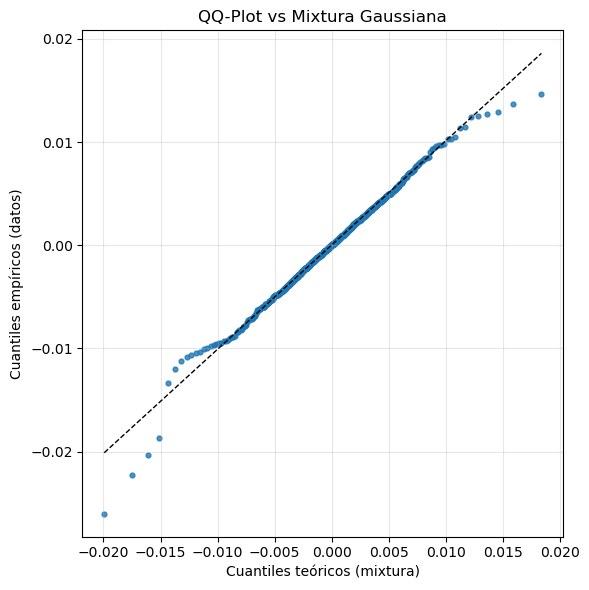

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ==========
# Utilidades mezcla
# ==========
def mix_cdf(x, pis, mus, sigmas):
    """F(x) = sum_k π_k * Φ((x-μ_k)/σ_k)"""
    x = np.asarray(x)
    pis, mus, sigmas = map(np.asarray, (pis, mus, sigmas))
    z = (x[..., None] - mus) / sigmas
    return np.sum(pis * norm.cdf(z), axis=-1)

def mix_ppf(p, pis, mus, sigmas, tol=1e-10, max_iter=200):
    """
    Inversa CDF por bisección para mezcla 1D.
    p puede ser escalar o array.
    """
    p = np.asarray(p, dtype=float)
    pis, mus, sigmas = map(np.asarray, (pis, mus, sigmas))
    # Rango amplio de búsqueda (colas de normales)
    lo = np.min(mus - 10 * sigmas.max())
    hi = np.max(mus + 10 * sigmas.max())
    lo = np.full_like(p, lo, dtype=float)
    hi = np.full_like(p, hi, dtype=float)

    for _ in range(max_iter):
        mid = (lo + hi) / 2.0
        Fmid = mix_cdf(mid, pis, mus, sigmas)
        lo = np.where(Fmid < p, mid, lo)
        hi = np.where(Fmid >= p, mid, hi)
        if np.max(hi - lo) < tol:
            break
    return (lo + hi) / 2.0

# ==========
# PP plot (empírico vs teórico mezcla)
# ==========
def pp_plot_mixture(x, pis, mus, sigmas, title="PP-Plot vs Mixtura Gaussiana"):
    x = np.asarray(x).ravel()
    x = x[~np.isnan(x)]
    n = x.size
    xs = np.sort(x)

    # Prob empíricos con corrección de Blom ~ (i-0.375)/(n+0.25)
    p_emp = (np.arange(1, n + 1) - 0.375) / (n + 0.25)

    # Prob teóricos evaluando F_mix en los datos ordenados
    p_th = mix_cdf(xs, pis, mus, sigmas)

    plt.figure(figsize=(6, 6))
    plt.scatter(p_th, p_emp, s=12, alpha=0.8)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("Probabilidad teórica F_mix(x)")
    plt.ylabel("Probabilidad empírica")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========
# QQ plot (cuantiles empíricos vs teóricos mezcla)
# ==========
def qq_plot_mixture(x, pis, mus, sigmas, title="QQ-Plot vs Mixtura Gaussiana"):
    x = np.asarray(x).ravel()
    x = x[~np.isnan(x)]
    n = x.size
    xs = np.sort(x)

    # Probabilidades "de cuantiles" (Blom)
    p = (np.arange(1, n + 1) - 0.375) / (n + 0.25)

    # Cuantiles teóricos de la mezcla (inversa CDF)
    q_th = mix_ppf(p, pis, mus, sigmas)

    plt.figure(figsize=(6, 6))
    plt.scatter(q_th, xs, s=12, alpha=0.8)
    # línea de referencia: recta por los cuantiles 25% y 75%
    q25_th, q75_th = np.quantile(q_th, [0.25, 0.75])
    q25_xs, q75_xs = np.quantile(xs,  [0.25, 0.75])
    slope = (q75_xs - q25_xs) / (q75_th - q25_th + 1e-18)
    intercept = q25_xs - slope * q25_th
    xr = np.array([q_th.min(), q_th.max()])
    plt.plot(xr, slope * xr + intercept, 'k--', lw=1)

    plt.xlabel("Cuantiles teóricos (mixtura)")
    plt.ylabel("Cuantiles empíricos (datos)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========
# Uso con tus datos y parámetros EM
# ==========
x = df.dropna().values  # si tu df es serie de 1 columna

pp_plot_mixture(x, pis, mus, sigmas)
qq_plot_mixture(x, pis, mus, sigmas)


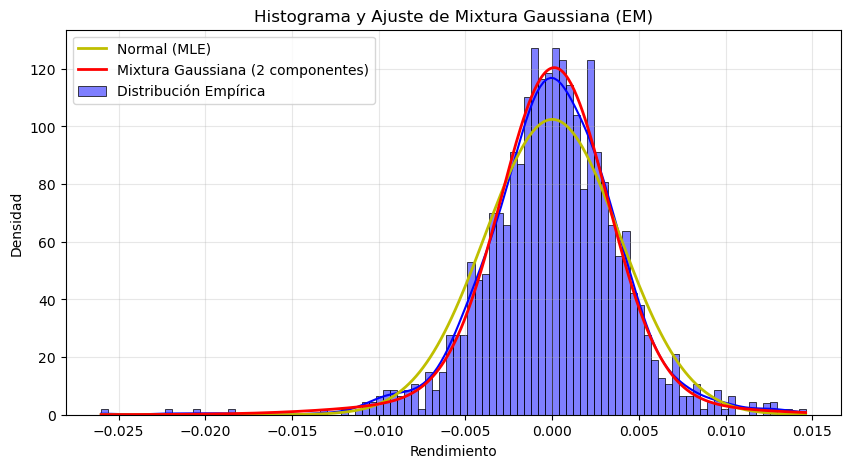

In [ ]:
# --- Histograma con KDE de los datos ---
plt.figure(figsize=(10, 5))
sns.histplot(df["Rendimientos IPC"], bins=100, kde=True, stat="density",
             color="blue", label='Distribución Empírica')

plt.title("Histograma y Ajuste de Mixtura Gaussiana (EM)")
plt.xlabel("Rendimiento")
plt.ylabel("Densidad")

# Curva de la normal ajustada
x = np.linspace(min(datos), max(datos), 200)
pdf = scipy.stats.norm.pdf(x, loc=mu_mle, scale=sigma_mle)
plt.plot(x, pdf, 'y-', lw=2, label='Normal (MLE)')

# --- Densidad de la mezcla ---
x_grid = np.linspace(df["Rendimientos IPC"].min(), df["Rendimientos IPC"].max(), 500)
pdf_mix = np.zeros_like(x_grid)

for pi, mu, sigma in zip(pis, mus, sigmas):
    pdf_mix += pi * norm.pdf(x_grid, loc=mu, scale=sigma)

plt.plot(x_grid, pdf_mix, 'r-', lw=2, label='Mixtura Gaussiana (2 componentes)')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# KS contra la mezcla
ks_mixture = kstest(x, lambda val: mix_cdf(val, pis, mus, sigmas))
print("\nKS test contra Mixtura Gaussiana")
print("Estadístico D:", ks_mixture.statistic)
print("p-valor:", ks_mixture.pvalue)



KS test contra Mixtura Gaussiana
Estadístico D: 0.44490940336958357
p-valor: 1.3249064465966251e-36
